In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import random
from sklearn.metrics import f1_score, recall_score
import matplotlib.pyplot as plt
import os
import json

In [2]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cuda:0


In [3]:
# Download and load the CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_set = datasets.CIFAR100(root='../data', train=True, download=True, transform=transform)
test_set = datasets.CIFAR100(root='../data', train=False, download=True, transform=transform)

# Split train data into train and validation
train_size = int(0.8 * len(train_set))
val_size = len(train_set) - train_size
train_dataset, val_dataset = random_split(train_set, [train_size, val_size])

batch_size = 1024
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# Function to set a random seed for reproducibility
def set_seed(seed=None):
    if seed is None:
        seed = np.random.randint(0, 10000)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    return seed

In [5]:
# Function for validation
def validate(net, val_loader, criterion):
    total_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    return total_loss / len(val_loader)

In [6]:
# Function to calculate test error
def calculate_test_error(net, test_loader):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_accuracy = 100 * correct / total
    return 100 - test_accuracy  # Test error

In [7]:
# Function for training
def train_model(net, train_loader, val_loader, test_loader, criterion, optimizer, epochs):
    train_losses = []
    val_losses = []
    test_errors = []
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        train_losses.append(running_loss / len(train_loader))
        val_loss = validate(net, val_loader, criterion)
        val_losses.append(val_loss)
        test_error = calculate_test_error(net, test_loader)
        test_errors.append(test_error)
        print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}, Test Error: {test_errors[-1]}')

    return train_losses, val_losses, test_errors

In [8]:
# Function to calculate accuracy, F1 score, and recall
def calculate_metrics(net, loader):
    net.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for data in loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    return accuracy, f1, recall

In [9]:
# ResNet-18 with no pre-trained weights
def initialize_model(device):
    net = models.resnet18(weights=None)
    num_features = net.fc.in_features

    # Adjusting for 100 classes in CIFAR-100
    net.fc = torch.nn.Linear(num_features, 100)
    net = net.to(device)

    return net

In [10]:
def initialize_loss_function():
    return nn.CrossEntropyLoss()

In [11]:
import swats

def initialize_optimizer(model_params):
    return swats.SWATS(model_params)

Run: 1
Seed: 2079


c:\Users\sbp5911\AppData\Local\Programs\Python\Python311\Lib\site-packages\swats\optim.py:126: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ..\torch\csrc\utils\python_arg_parser.cpp:1519.)
  exp_avg.mul_(beta1).add_(1 - beta1, grad)


Epoch 1/200, Train Loss: 3.7091275632381437, Validation Loss: 3.2870852947235107, Test Error: 82.61
Epoch 2/200, Train Loss: 4.082094234228134, Validation Loss: 3.8017148971557617, Test Error: 88.38
Epoch 3/200, Train Loss: 3.3932022511959077, Validation Loss: 3.374760460853577, Test Error: 81.35
Epoch 4/200, Train Loss: 3.119758480787277, Validation Loss: 3.1331446170806885, Test Error: 76.65
Epoch 5/200, Train Loss: 2.874384564161301, Validation Loss: 3.1474803924560546, Test Error: 75.85
Epoch 6/200, Train Loss: 2.684809708595276, Validation Loss: 2.9246824741363526, Test Error: 72.23
Epoch 7/200, Train Loss: 2.4680743396282194, Validation Loss: 3.124184274673462, Test Error: 73.92
Epoch 8/200, Train Loss: 2.359366571903229, Validation Loss: 2.95561363697052, Test Error: 71.88
Epoch 9/200, Train Loss: 2.143161141872406, Validation Loss: 3.226490044593811, Test Error: 74.08
Epoch 10/200, Train Loss: 2.0380746603012083, Validation Loss: 3.066247320175171, Test Error: 71.19
Epoch 11/20

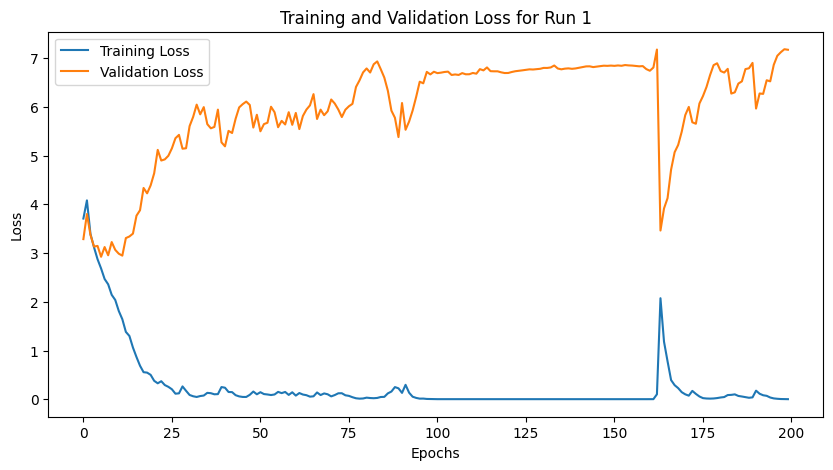

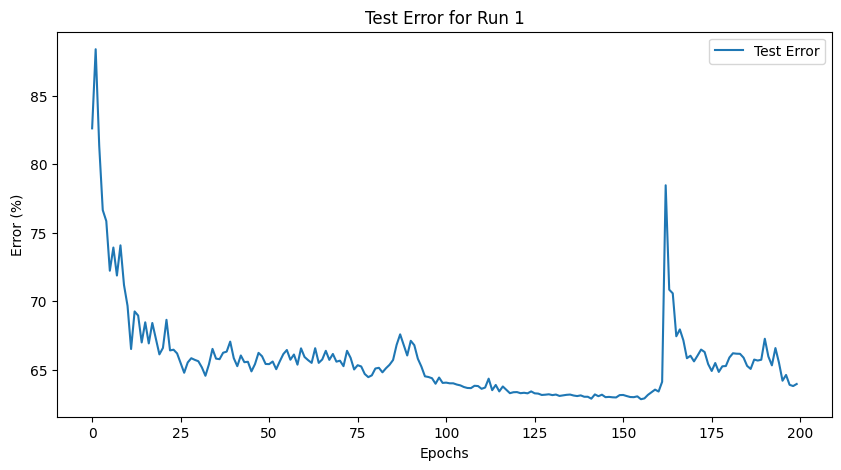

Run: 2
Seed: 5354
Epoch 1/200, Train Loss: 3.7144895255565644, Validation Loss: 3.294822883605957, Test Error: 81.92
Epoch 2/200, Train Loss: 4.05142428278923, Validation Loss: 4.06059684753418, Test Error: 90.49
Epoch 3/200, Train Loss: 3.462735617160797, Validation Loss: 3.340308117866516, Test Error: 80.23
Epoch 4/200, Train Loss: 3.1124522984027863, Validation Loss: 3.494363880157471, Test Error: 81.41
Epoch 5/200, Train Loss: 2.980873817205429, Validation Loss: 3.1577996253967284, Test Error: 75.78
Epoch 6/200, Train Loss: 2.7497034788131716, Validation Loss: 3.1224788188934327, Test Error: 75.22
Epoch 7/200, Train Loss: 2.5872573852539062, Validation Loss: 3.009786343574524, Test Error: 72.39
Epoch 8/200, Train Loss: 2.4009806513786316, Validation Loss: 2.8702720165252686, Test Error: 70.57
Epoch 9/200, Train Loss: 2.2415730595588683, Validation Loss: 2.7887221574783325, Test Error: 68.22
Epoch 10/200, Train Loss: 2.0007213354110718, Validation Loss: 3.0146146059036254, Test Erro

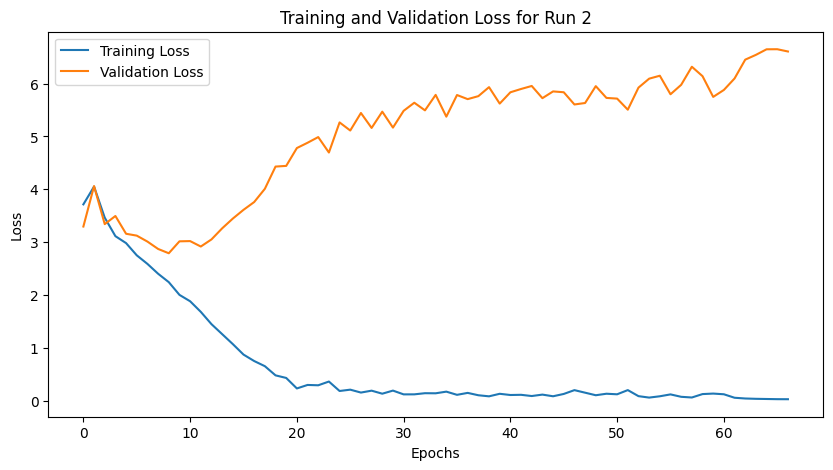

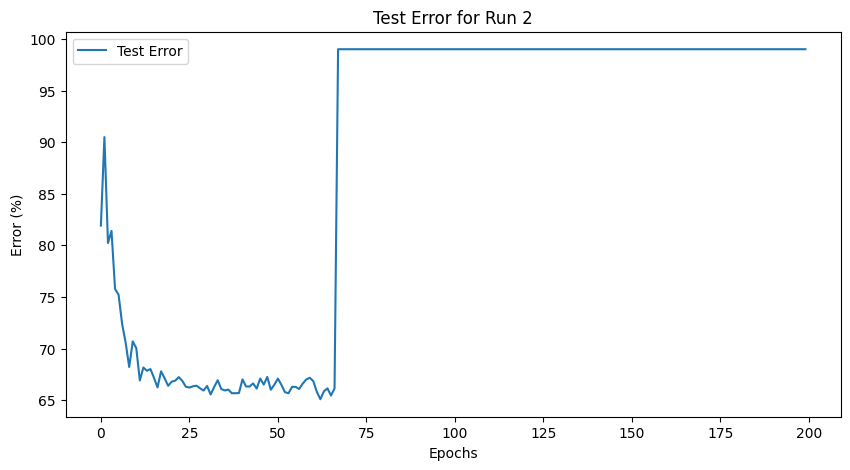

Run: 3
Seed: 3040
Epoch 1/200, Train Loss: 3.709663301706314, Validation Loss: 3.2673229455947874, Test Error: 80.25
Epoch 2/200, Train Loss: 3.688693326711655, Validation Loss: 3.4709041118621826, Test Error: 83.97
Epoch 3/200, Train Loss: 3.1962125420570375, Validation Loss: 3.4754504680633547, Test Error: 81.46000000000001
Epoch 4/200, Train Loss: 2.9857421278953553, Validation Loss: 3.6222069025039674, Test Error: 82.01
Epoch 5/200, Train Loss: 2.825530934333801, Validation Loss: 2.95565345287323, Test Error: 73.36
Epoch 6/200, Train Loss: 2.5610275089740755, Validation Loss: 2.9603038311004637, Test Error: 72.49
Epoch 7/200, Train Loss: 2.352080738544464, Validation Loss: 2.888355088233948, Test Error: 70.71000000000001
Epoch 8/200, Train Loss: 2.189096760749817, Validation Loss: 2.863400363922119, Test Error: 69.65
Epoch 9/200, Train Loss: 1.9688692301511765, Validation Loss: 2.832458233833313, Test Error: 67.46000000000001
Epoch 10/200, Train Loss: 1.7313887506723404, Validation

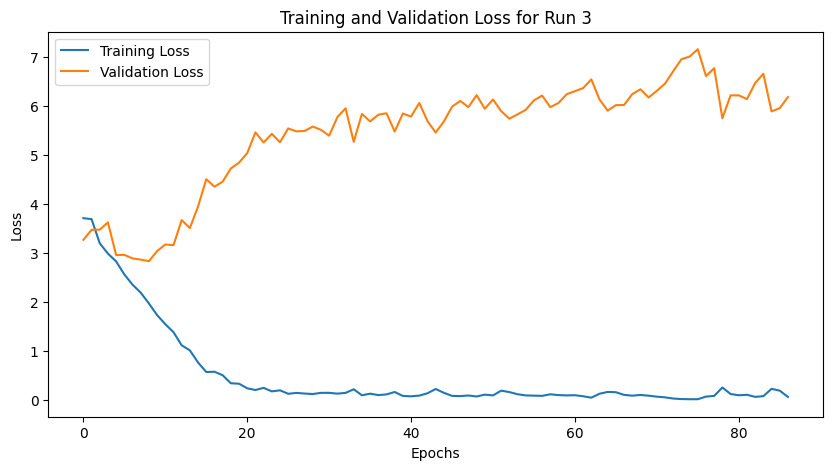

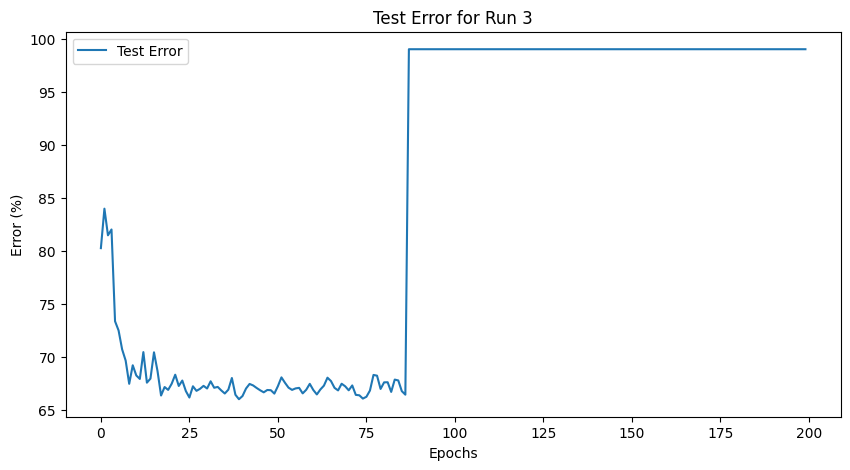

Run: 4
Seed: 3175
Epoch 1/200, Train Loss: 3.733479517698288, Validation Loss: 3.3090439558029177, Test Error: 82.96000000000001
Epoch 2/200, Train Loss: 4.12373925447464, Validation Loss: 3.6918133020401003, Test Error: 87.33
Epoch 3/200, Train Loss: 3.4882530093193056, Validation Loss: 3.391533899307251, Test Error: 81.68
Epoch 4/200, Train Loss: 3.1922868132591247, Validation Loss: 3.3594958782196045, Test Error: 80.14
Epoch 5/200, Train Loss: 2.995797801017761, Validation Loss: 3.2073227167129517, Test Error: 77.95
Epoch 6/200, Train Loss: 2.8156077206134795, Validation Loss: 3.1646613121032714, Test Error: 76.93
Epoch 7/200, Train Loss: 2.6411098420619963, Validation Loss: 2.900548982620239, Test Error: 72.07
Epoch 8/200, Train Loss: 2.4795992016792296, Validation Loss: 2.8242422103881837, Test Error: 70.03
Epoch 9/200, Train Loss: 2.2749931454658507, Validation Loss: 2.820869541168213, Test Error: 69.01
Epoch 10/200, Train Loss: 2.1433020412921904, Validation Loss: 2.934090662002

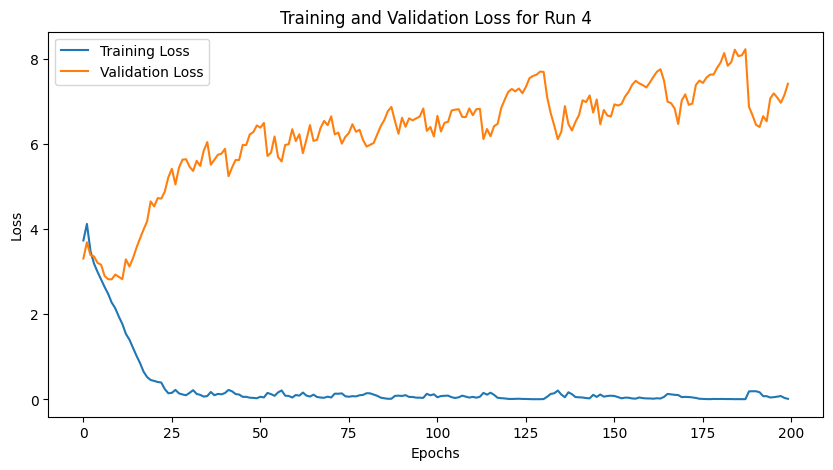

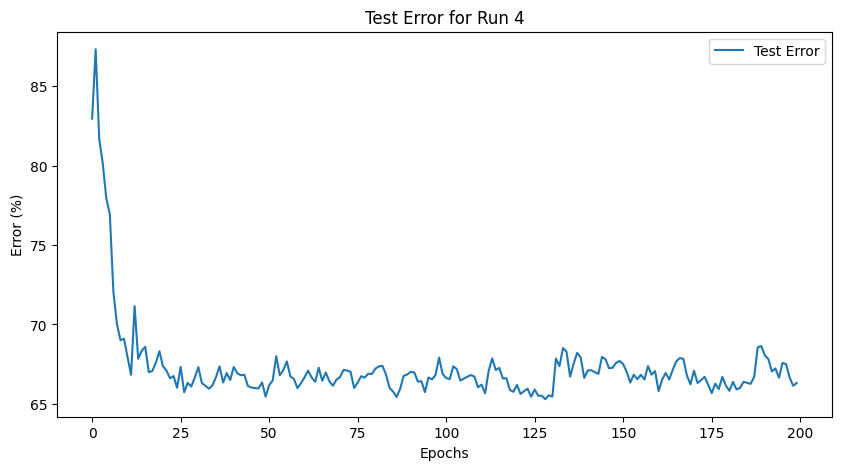

Run: 5
Seed: 7753
Epoch 1/200, Train Loss: 3.725195449590683, Validation Loss: 3.274727940559387, Test Error: 82.6
Epoch 2/200, Train Loss: 4.092729634046554, Validation Loss: 3.7142146825790405, Test Error: 87.26
Epoch 3/200, Train Loss: 3.4518272280693054, Validation Loss: 3.571895170211792, Test Error: 83.97
Epoch 4/200, Train Loss: 3.1746967136859894, Validation Loss: 3.274041843414307, Test Error: 79.51
Epoch 5/200, Train Loss: 2.9620110213756563, Validation Loss: 3.0684173107147217, Test Error: 74.88
Epoch 6/200, Train Loss: 2.754346752166748, Validation Loss: 2.9422001361846926, Test Error: 72.96000000000001
Epoch 7/200, Train Loss: 2.5641965508460998, Validation Loss: 2.8987281799316404, Test Error: 72.24
Epoch 8/200, Train Loss: 2.3799973130226135, Validation Loss: 2.9636067152023315, Test Error: 71.49
Epoch 9/200, Train Loss: 2.2435028851032257, Validation Loss: 2.914921689033508, Test Error: 70.32
Epoch 10/200, Train Loss: 2.088634026050568, Validation Loss: 2.88647477626800

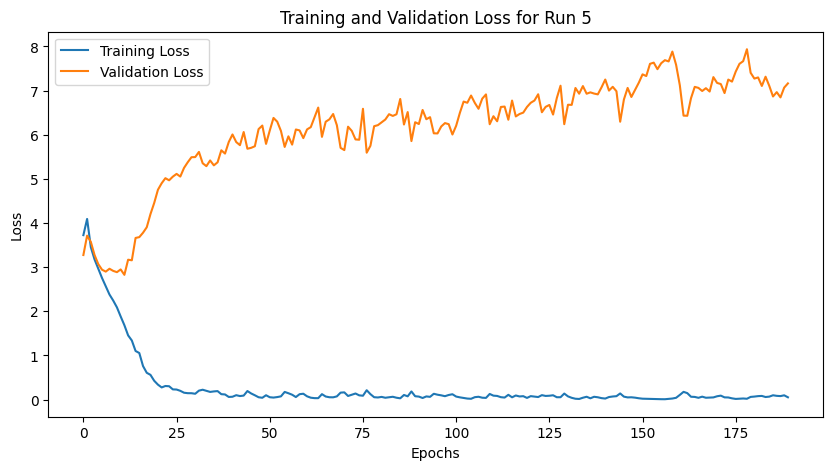

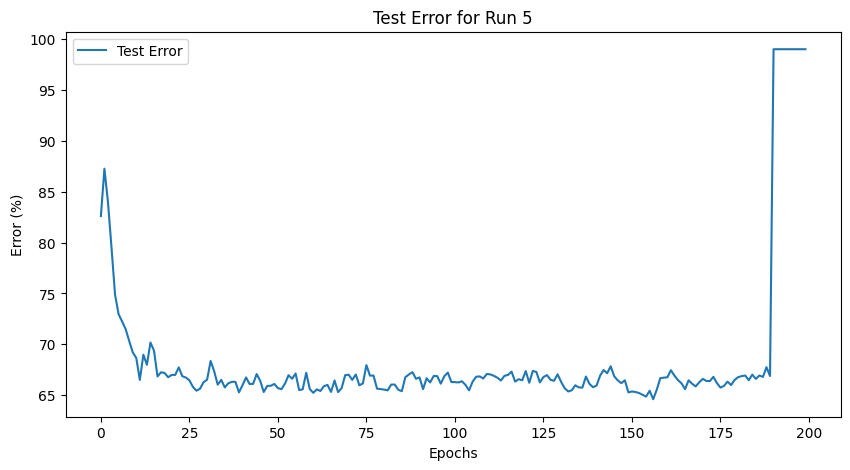

In [12]:
# Run the training for 5 different seeds
num_runs = 5
epochs = 200
metrics = {
    'seed': [],
    'train_losses': [],
    'val_losses': [],
    'test_errors': [],
    'val_accuracy': [],
    'val_f1': [],
    'val_recall': [],
    'test_accuracy': [],
    'test_f1': [],
    'test_recall': []
}



# Initialize dictionaries to store results
results = {
    'train_losses': [],
    'val_losses': [],
    'test_errors': []
}

for run in range(num_runs):
    print(f"Run: {run + 1}")
    seed = set_seed()
    print(f"Seed: {seed}")

    # Reinitialize the model, loss function, and optimizer
    net = initialize_model(device=device)
    criterion = initialize_loss_function()
    optimizer = initialize_optimizer(model_params=net.parameters())

    # Train the network
    train_losses, val_losses, test_errors = train_model(net, train_loader, val_loader, test_loader, criterion, optimizer, epochs)
    metrics['test_errors'].append(test_errors)

    # Calculate metrics on validation and test sets
    val_accuracy, val_f1, val_recall = calculate_metrics(net, val_loader)
    test_accuracy, test_f1, test_recall = calculate_metrics(net, test_loader)
    
    # Print metrics for validation set
    print(f"Run {run + 1} - Validation Metrics:")
    print(f"    Accuracy: {val_accuracy}%")
    print(f"    F1 Score: {val_f1}")
    print(f"    Recall:   {val_recall}")

    # Print metrics for test set
    print(f"Run {run + 1} - Test Metrics:")
    print(f"    Accuracy: {test_accuracy}%")
    print(f"    F1 Score: {test_f1}")
    print(f"    Recall:   {test_recall}")
    
    # Store metrics
    metrics['seed'].append(seed)
    metrics['train_losses'].append(train_losses)
    metrics['val_losses'].append(val_losses)
    metrics['val_accuracy'].append(val_accuracy)
    metrics['val_f1'].append(val_f1)
    metrics['val_recall'].append(val_recall)
    metrics['test_accuracy'].append(test_accuracy)
    metrics['test_f1'].append(test_f1)
    metrics['test_recall'].append(test_recall)
    
    # Append the results for the current run
    results['train_losses'].append(metrics['train_losses'][run])
    results['val_losses'].append(metrics['val_losses'][run])
    results['test_errors'].append(metrics['test_errors'][run])

    # Plot for training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(metrics['train_losses'][run], label='Training Loss')
    plt.plot(metrics['val_losses'][run], label='Validation Loss')
    plt.title(f"Training and Validation Loss for Run {run+1}")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot for test error
    plt.figure(figsize=(10, 5))
    plt.plot(metrics['test_errors'][run], label='Test Error')
    plt.title(f"Test Error for Run {run+1}")
    plt.xlabel('Epochs')
    plt.ylabel('Error (%)')
    plt.legend()
    plt.show()

Mean Metrics: {'val_accuracy': 14.34, 'val_f1': 0.1374655970069636, 'val_recall': 0.1434, 'test_accuracy': 14.544, 'test_f1': 0.1391419624008885, 'test_recall': 0.14544}
Standard Deviation of Metrics: {'val_accuracy': 16.421710020579468, 'val_f1': 0.16834437483673967, 'val_recall': 0.16421710020579466, 'test_accuracy': 16.60444109267156, 'test_f1': 0.1703227479777106, 'test_recall': 0.16604441092671562}


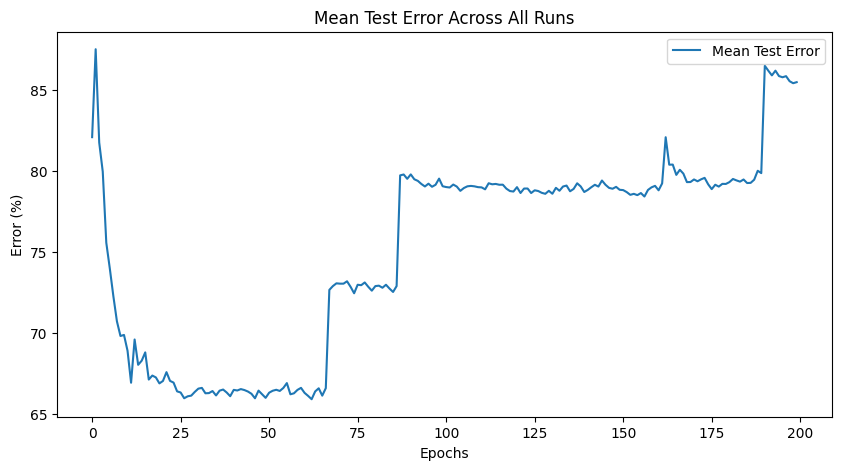

In [13]:
# Calculate mean and standard deviation across runs
mean_metrics = {metric: np.mean(metrics[metric]) for metric in metrics if metric not in ['seed', 'train_losses', 'val_losses', 'test_errors']}
std_metrics = {metric: np.std(metrics[metric]) for metric in metrics if metric not in ['seed', 'train_losses', 'val_losses', 'test_errors']}

# Print mean metrics and standard deviation
print("Mean Metrics:", mean_metrics)
print("Standard Deviation of Metrics:", std_metrics)

# Calculate mean test error across all runs
mean_test_errors = np.mean(metrics['test_errors'], axis=0)

# Plot mean test error
plt.figure(figsize=(10, 5))
plt.plot(mean_test_errors, label='Mean Test Error')
plt.title("Mean Test Error Across All Runs")
plt.xlabel('Epochs')
plt.ylabel('Error (%)')
plt.legend()
plt.show()

In [14]:
# Directory for saving results
save_dir = 'ResNet18_Results_CIFAR_100'
os.makedirs(save_dir, exist_ok=True)

# Save the results to a file
with open(os.path.join(save_dir, 'SWATS.json'), 'w') as f:
    json.dump(results, f)